##### Statistics 504 Homework #2 <br>
10/30/2015 <br>
Fall 2015 <br>
Erich Seamon <br>
University of Idaho <br>
erichs@uidaho.edu <br>
http://github.com/erichseamon.com/stat504-python <br>

This assignment uses a small subset of the data from Kaggle's Yelp Business Rating Prediction competition. The data set is at https://github.com/justmarkham/DAT7/tree/master/data/yelp.csv
Description of the data: Each observation in this dataset is a review of a particular business by a particular user. The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) The "cool" column is the number of "cool" votes this particular review received from other Yelp users. There is no limit to how many "cool" votes a review can receive. The "useful" and "funny" columns are similar to the "cool" column.


#### TASK 1: read yelp.csv into a DataFrame

In [185]:
import matplotlib
%matplotlib nbagg

import pandas as pd
import numpy as np
import random
from sklearn.cross_validation import train_test_split
#random.seed(1234567) #setting the random seed for reproducible results consistent across our class - fall 2015
yelp = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT7/master/data/yelp.csv')

#### TASK 2: create a new DataFrame that only contains the 5-star and 1-star reviews.

In [186]:
yelp_best_worst = yelp[(yelp.stars==5) | (yelp.stars==1)]

#### TASK 3: Use a random seed 1234567, split the new DataFrame into training and testing sets

In [187]:
feature_cols = ['text', 'cool', 'useful', 'funny']
yelp_best_worst_featureadd = yelp_best_worst[feature_cols] #for use in Task 6
X = yelp_best_worst_featureadd.text
y = yelp_best_worst.stars

X_train, X_test, y_train, y_test = train_test_split(yelp_best_worst_featureadd, yelp_best_worst.stars, random_state=1234567)

In [188]:
#from sklearn.cross_validation import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(yelp_best_worst.text, yelp_best_worst.stars, random_state=1234567)

#### TASK 4: use CountVectorizer to create document-term matrices from X_train and X_test

In [189]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X_dtm = vect.fit_transform(X)
train_dtm = vect.fit_transform(X_train.text)
test_dtm = vect.transform(X_test.text)



In [190]:
#vect2 = CountVectorizer()
#X = vect2.fit_transform(yelp_best_worst.text)
#y = yelp_best_worst.stars

#### TASK 5a: use Logistic Regression to predict the star rating for the testing set, and calculate accuracy

In [191]:
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(train_dtm, y_train)
y_pred_class = logreg.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.936399217221


#### TASK 5b: use K-Nearest Neighbors to predict the star rating for the testing set, and calculate accuracy

In [192]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=8) # - run with K = 8 - produces lowest testing error.  See results below.
neigh.fit(train_dtm, y_train)
y_pred_class = neigh.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.835616438356


###### Calculate TRAINING ERROR and TESTING ERROR for K=1 through 50 for K-Nearest Neighbors

In [193]:
# calculate TRAINING ERROR and TESTING ERROR for K=1 through 50
k_range = range(1, 50) #- ran this with 50.  I ran with k = 3000, it didnt give me any more useful information.
training_error = [] 
testing_error = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # training error
    knn.fit(X_dtm, y)
    y_pred = knn.predict(X_dtm)
    training_error.append(1 - metrics.accuracy_score(y, y_pred))
    # testing error
    knn.fit(train_dtm, y_train)
    y_pred = knn.predict(test_dtm)
    testing_error.append(1 - metrics.accuracy_score(y_test, y_pred))

In [194]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### Plot the relationship between K (HIGH TO LOW) and TESTING ERROR

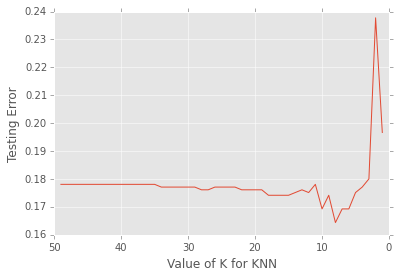

In [195]:
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
plt.plot(k_range, testing_error)
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Error')

#### NOTE:  It looks like a K = 8 would produce the lowest testing error

In [196]:
df = pd.DataFrame({'K': k_range, 'train':training_error, 'test':testing_error}).set_index('K').sort_index(ascending=False)

#### Plot both test and train datasets for k and test error

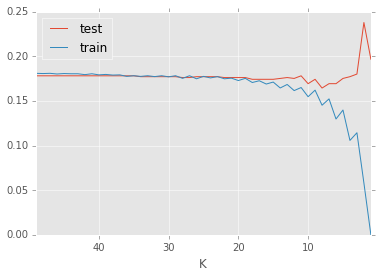

In [197]:
df.plot()

#### TASK 5c: use Classification Tree to predict the star rating for the testing set, and calculate accuracy

In [198]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=15)
clf.fit(train_dtm, y_train)
y_pred_class = clf.predict(test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.861056751468


In [199]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

In [200]:
graph.write_jpeg("yelp_tree_plot.jpg")

True

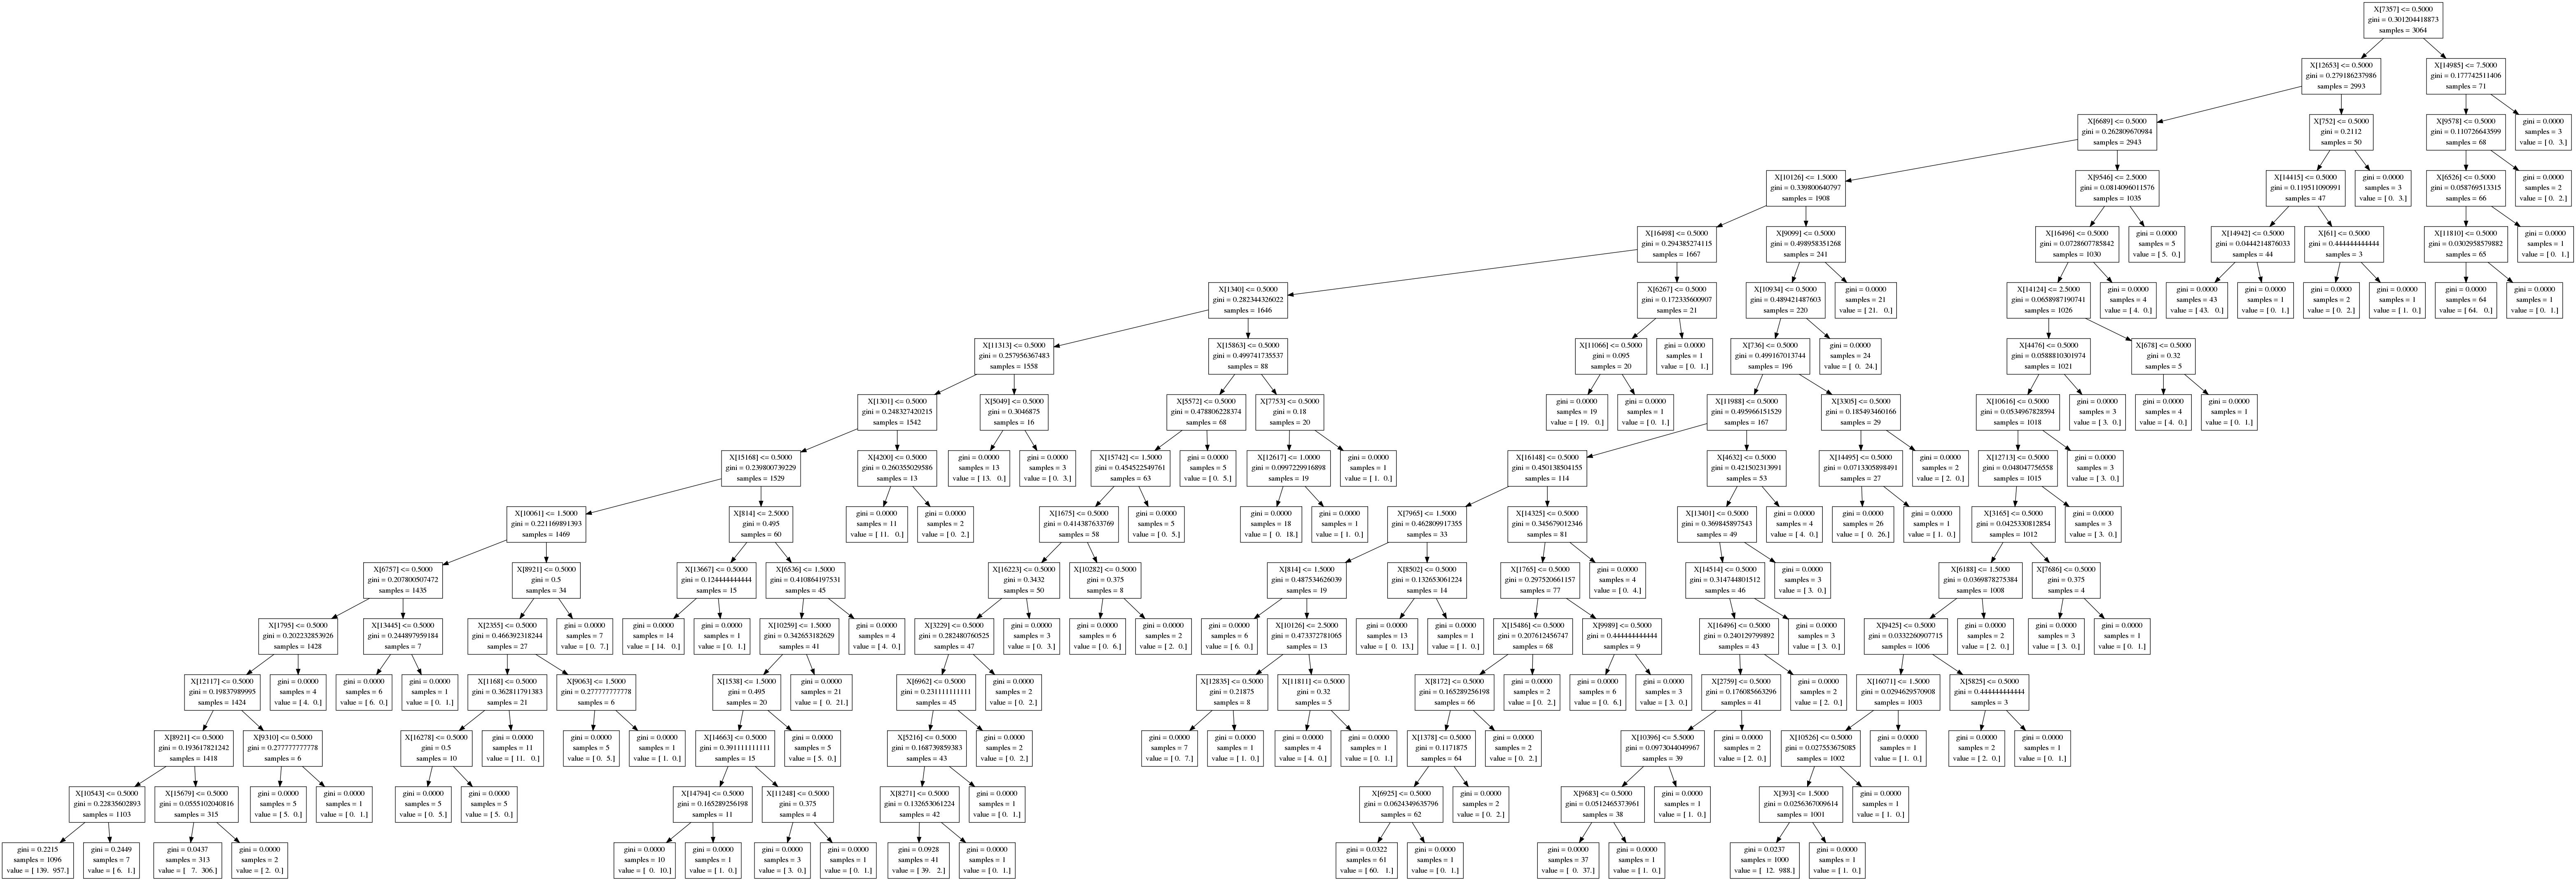

In [201]:
from IPython.display import Image
Image(filename='yelp_tree_plot.jpg')

### Calculate AUC and ROC for all three models

#### TASK 6a: calculate the logistic regression AUC

In [202]:
# TASK 6: calculate the logistic regression AUC
log_y_pred_prob = logreg.predict_proba(test_dtm)[:, 1]
import numpy as np
log_y_test_binary = np.where(y_test==5, 1, 0)
auc_log1 = metrics.roc_auc_score(log_y_test_binary, log_y_pred_prob)
print auc_log1

0.962367377245


#### TASK 6b: calculate the k nearest neighbors AUC

In [203]:
# TASK 6: calculate the k nearest neighbors AUC
knn_y_pred_prob = neigh.predict_proba(test_dtm)[:, 1]
import numpy as np
knn_y_test_binary = np.where(y_test==5, 1, 0)
auc_knn1 = metrics.roc_auc_score(knn_y_test_binary, knn_y_pred_prob)
print auc_knn1

0.728475872265


#### TASK 6c: calculate the classification tree AUC

In [204]:
# TASK 6: calculate the k nearest neighbors AUC
tree_y_pred_prob = clf.predict_proba(test_dtm)[:, 1]
import numpy as np
tree_y_test_binary = np.where(y_test==5, 1, 0)
auc_tree1 = metrics.roc_auc_score(tree_y_test_binary, tree_y_pred_prob)
print auc_tree1

0.701055771573


#### TASK 7: plot the ROC curves for all three models

<IPython.core.display.Javascript object>


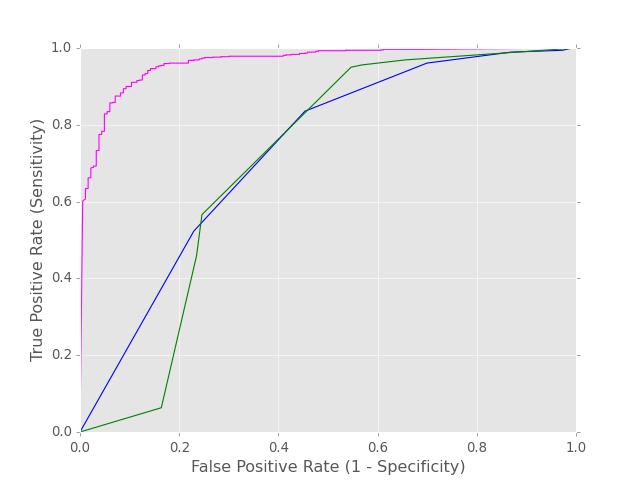

In [205]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg

import matplotlib.pyplot as plt

roc_knn1 = metrics.roc_curve(knn_y_test_binary, knn_y_pred_prob)
knn_fpr, knn_tpr, thresholds = roc_knn1
plt.plot(knn_fpr, knn_tpr, color='blue')

roc_log1 = metrics.roc_curve(log_y_test_binary, log_y_pred_prob)
log_fpr, log_tpr, thresholds = roc_log1
plt.plot(log_fpr, log_tpr, color='magenta')

roc_tree1 = metrics.roc_curve(tree_y_test_binary, tree_y_pred_prob)
tree_fpr, tree_tpr, thresholds = roc_tree1
plt.plot(tree_fpr, tree_tpr, color='green')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

#### TASK 8: Add vote types (cool/useful/funny) as an additional features into the modeling process and refit the three models to predict the star rating in the testing set, and calculate the AUC and plot the ROC Curve for the three models. Any improvement or not? Comment on your findings.

In [206]:
del X_train['text']
del X_test['text']

#feature_cols = ['cool', 'useful', 'funny']
#yelp_best_worst_featureadd = yelp_best_worst[feature_cols] #for use in Task 6

#X_train, X_test, y_train, y_test = train_test_split(yelp_best_worst_featureadd, yelp_best_worst.stars, random_state=1234567)

In [207]:
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.834637964775


In [208]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=11)
neigh.fit(X_train, y_train)
y_pred_class = neigh.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.827788649706


##### calculate TRAINING ERROR and TESTING ERROR for K=1 through 50 - Cool Useful Funny features


In [210]:
del yelp_best_worst_featureadd['text']
X = yelp_best_worst_featureadd
# calculate TRAINING ERROR and TESTING ERROR for K=1 through 50
k_range = range(1, 50) #- ran this with 50.  I ran with k = 3000, it didnt give me any more useful information.
training_error = [] 
testing_error = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # training error
    knn.fit(X, y)
    y_pred = knn.predict(X)
    training_error.append(1 - metrics.accuracy_score(y, y_pred))
    # testing error
    knn2.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    testing_error.append(1 - metrics.accuracy_score(y_test, y_pred))

In [211]:
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
df2 = pd.DataFrame(testing_error, k_range)
plt.plot(k_range, testing_error)
plt.gca().invert_xaxis()
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Error')

<IPython.core.display.Javascript object>


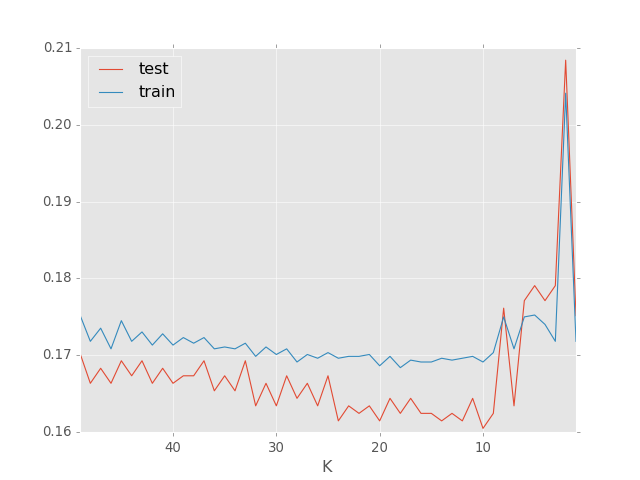

In [225]:
df3 = pd.DataFrame({'K': k_range, 'train':training_error, 'test':testing_error}).set_index('K').sort_index(ascending=False)
df3.plot()

In [213]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_class = clf.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.824853228963


In [214]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data2 = StringIO() 
tree.export_graphviz(clf, out_file=dot_data2)
graph = pydot.graph_from_dot_data(dot_data2.getvalue()) 

In [215]:
graph.write_jpeg("yelp_tree_plot2.jpg")

True

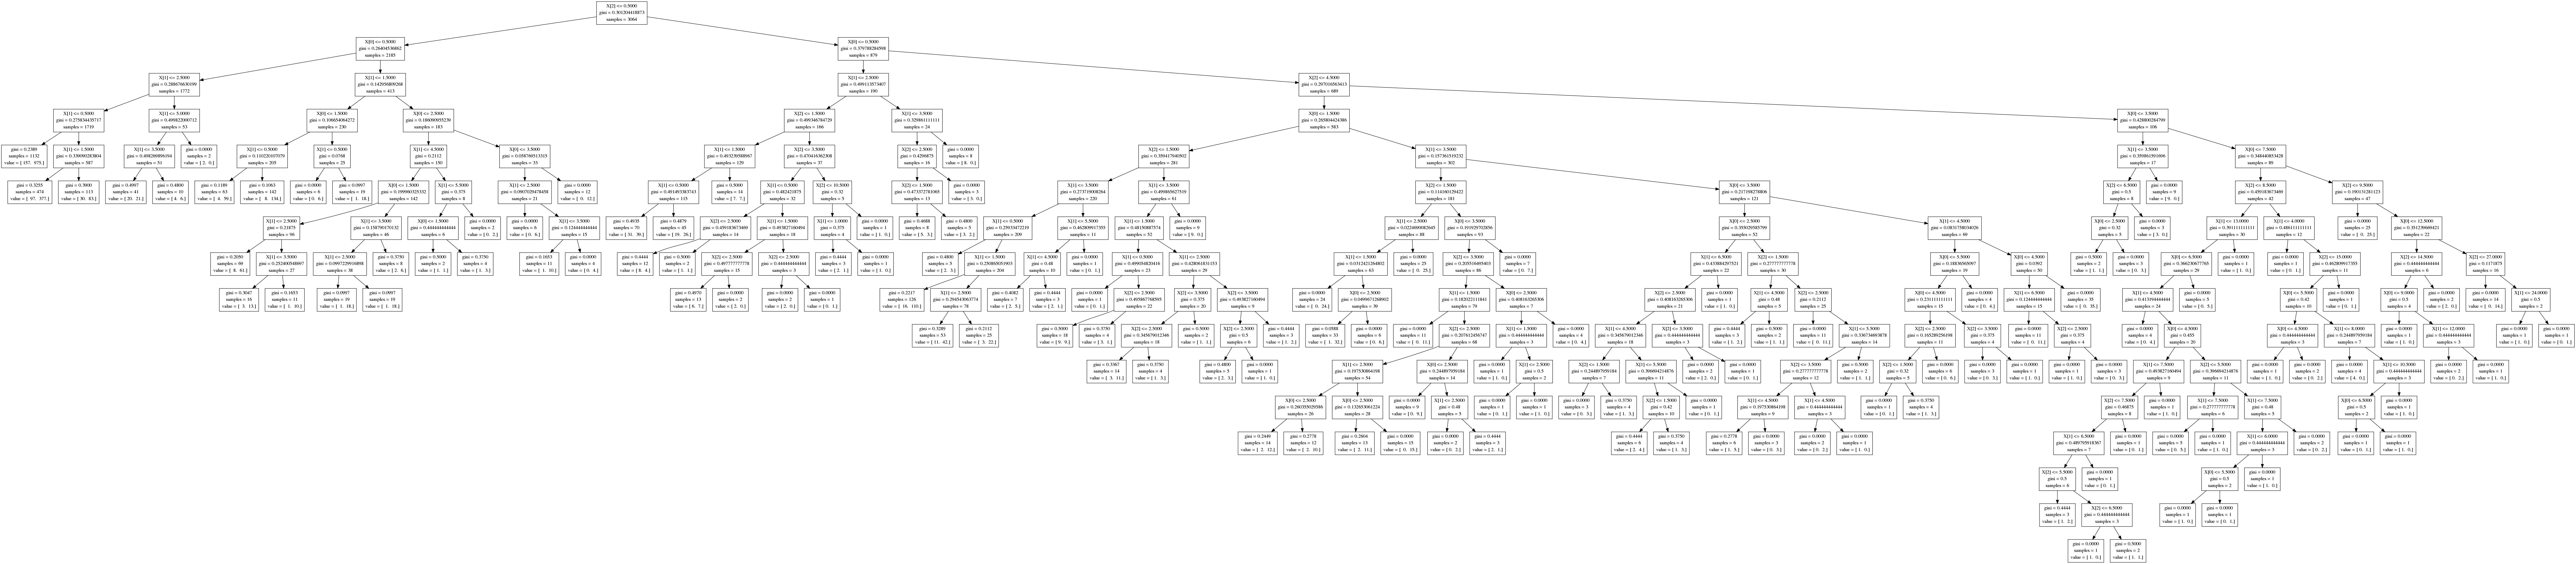

In [216]:
from IPython.display import Image
Image(filename='yelp_tree_plot2.jpg')

#### ABOVE: Decision Tree for Cool - Useful - Funny Features

### TASK 9: Calculate AUC for newly fitted models using cool.useful.funny features
##### TASK 9a: calculate the logistic regression AUC


In [217]:
log_y_pred_prob = logreg.predict_proba(X_test)[:, 1]
import numpy as np
log_y_test_binary = np.where(y_test==5, 1, 0)
auc_log2 = metrics.roc_auc_score(log_y_test_binary, log_y_pred_prob)
print auc_log2

0.674433524167


##### TASK 9b: calculate the k nearest neighbor AUC

In [218]:
# TASK 6: calculate the k nearest neighbors AUC
knn_y_pred_prob = neigh.predict_proba(X_test)[:, 1]
import numpy as np
knn_y_test_binary = np.where(y_test==5, 1, 0)
auc_knn2 = metrics.roc_auc_score(knn_y_test_binary, knn_y_pred_prob)
print auc_knn2

0.651455349525


##### TASK 9c: calculate the Decision Tree AUC

In [219]:
tree_y_pred_prob = clf.predict_proba(X_test)[:, 1]
import numpy as np
tree_y_test_binary = np.where(y_test==5, 1, 0)
auc_tree2 = metrics.roc_auc_score(tree_y_test_binary, tree_y_pred_prob)
print auc_tree2

0.620387919524


#### TASK 10: plot the ROC curves for all three models for the features 'cool', 'useful', and 'funny':

<IPython.core.display.Javascript object>


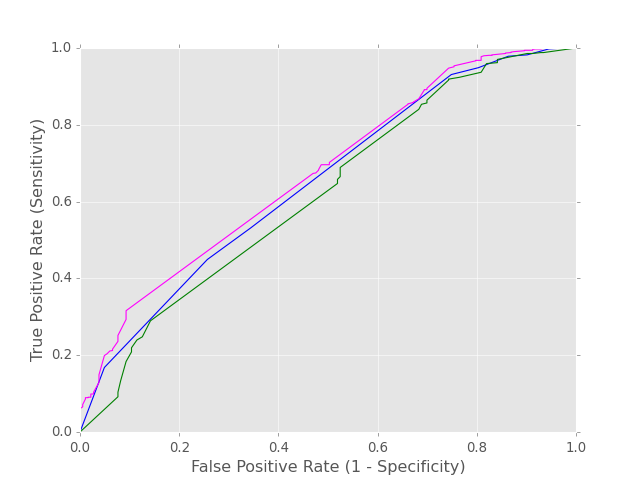

In [220]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg

import matplotlib.pyplot as plt
roc_knn2 = metrics.roc_curve(knn_y_test_binary, knn_y_pred_prob)
knn_fpr2, knn_tpr2, thresholds2 = roc_knn2
plt.plot(knn_fpr2, knn_tpr2, color='blue')

roc_log2 = metrics.roc_curve(log_y_test_binary, log_y_pred_prob)
log_fpr2, log_tpr2, thresholds2 = roc_log2
plt.plot(log_fpr2, log_tpr2, color='magenta')

roc_tree2 = metrics.roc_curve(tree_y_test_binary, tree_y_pred_prob)
tree_fpr2, tree_tpr2, thresholds2 = roc_tree2
plt.plot(tree_fpr2, tree_tpr2, color='green')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

##### Task 11: Any improvement or not? Comment on your findings

##### Comparing AUCs for all models for both types of features: 1) text, and 2) cool-useful-funny

In [221]:
mydata =[{auc_log1, auc_knn1, auc_tree1}, {auc_log2, auc_knn2, auc_tree2}]

In [222]:
df = pd.DataFrame(mydata)

In [233]:
model_compare = pd.DataFrame(mydata)
model_compare.index = ['text models', 'cool-useful-funny models']
model_compare.columns = ['auc tree', 'auc log', 'auc knn']

In [234]:
model_compare

,auc tree,auc log,auc knn
text models,0.701056,0.962367,0.728476
cool-useful-funny models,0.620388,0.674434,0.651455


##### NARRATIVE:

In review of of the ROCs and AUCs for each model (text vs. cool/useful/funny), for each predictive test (logistical regression, knn, and decision tree) the following AUC breakdown was found:

In review of the above, the text model performed better for all three predictive tests, with all three AUCs being lower.

In addition, the text model, when reviewing the ROC's, had differing results for the increase of specificity vs. sensitivity.  Logistical Regression was the one predictive model that had a more sinusoidal ROC, vs a an increasing linear ROC for knn and tree.  See the two diagrams above.

The cool-useful-funny model showed no real differences between each of the predictive models, with all AUCs being within 5%.

The interpretation of these two models, in comparision - is that given our limited training / test model, that does not utilize cross validation - yes, the text data seems provide a better source for varied predictive model analysis.  However, some more fine tuning of these model parameters, plus including CV - we might improve upon our alternative model performance.